# Comments  
- Automate Feature Selection [X]
- Automate Hyperparameters [X]
- Improve Feature Engineering [O]
- Deal with NaNs [X]

# Imports

In [943]:
import pandas as pd
import numpy as np
from numpy import mean
from numpy import std
import math
import time

import warnings
warnings.filterwarnings('ignore')

from sklearnex import patch_sklearn
patch_sklearn()

# Visualization
import matplotlib.pyplot as plt
from matplotlib import rcParams
%matplotlib inline
import seaborn as sns

# Feature and Model Selection
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif
from category_encoders import TargetEncoder
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import RandomizedSearchCV

# Models
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from catboost import CatBoostClassifier

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


# Data Loading

In [944]:
# !wget https://raw.githubusercontent.com/BKHV/risk_models/master/data/PD-data-train.csv
# !wget https://raw.githubusercontent.com/BKHV/risk_models/master/data/PD-data-test.csv
# !wget https://raw.githubusercontent.com/BKHV/risk_models/master/data/PD-data-desc.csv

In [945]:
train_df = pd.read_csv('PD-data-train.csv', sep=';')
test_df = pd.read_csv('PD-data-test.csv', sep=';')
desc_df = pd.read_csv('PD-data-desc.csv', sep=';')

In [946]:
df = pd.concat([train_df, test_df], sort=False)

# EDA

### General Information

In [947]:
print('Number of rows in test dataframe: ', test_df.shape[0])
print('Number of columns in test dataframe: ', test_df.shape[1])
print('Number of values in test dataframe: ', test_df.count().sum())
print('Number of NaNs in test dataframe: ', sum(test_df.isna().sum()))

Number of rows in test dataframe:  200
Number of columns in test dataframe:  36
Number of values in test dataframe:  4368
Number of NaNs in test dataframe:  2832


In [948]:
print('Number of rows in train dataframe: ', train_df.shape[0])
print('Number of columns in train dataframe: ', train_df.shape[1])
print('Number of values in train dataframe: ', train_df.count().sum())
print('Number of NaNs in train dataframe: ', sum(train_df.isna().sum()))

Number of rows in train dataframe:  32395
Number of columns in train dataframe:  37
Number of values in train dataframe:  835135
Number of NaNs in train dataframe:  363480


In [949]:
print('Number of rows in dataframe: ', df.shape[0])
print('Number of columns in dataframe: ', df.shape[1])
print('Number of values in dataframe: ', df.count().sum())
print('Number of NaNs in dataframe: ', sum(df.isna().sum()))

Number of rows in dataframe:  32595
Number of columns in dataframe:  37
Number of values in dataframe:  839503
Number of NaNs in dataframe:  366512


### Missing Values

In [950]:
print('Number of NaNs in train_df in all columns:\n')
count = df.isnull().sum().sort_values(ascending=False)
percentage = ((df.isnull().sum()/len(df)*100)).sort_values(ascending=False)
missing = pd.concat([count, percentage], axis=1, keys=['Count','Percentage'])
missing

Number of NaNs in train_df in all columns:



,Count,Percentage
ab_losses,15263,46.826200
ab_other_borrowings,15263,46.826200
ab_short_term_borrowing,15263,46.826200
ab_long_term_liabilities,15263,46.826200
ab_borrowed_capital,15263,46.826200
ab_own_capital,15263,46.826200
ar_revenue,15263,46.826200
ab_cash_and_securities,15263,46.826200
ab_other_current_assets,15263,46.826200
ab_accounts_receivable,15263,46.826200


### Distribution of Data Points among Output Class

In [951]:
df['default_12m'].value_counts()

0.0    30304
1.0     2091
Name: default_12m, dtype: int64

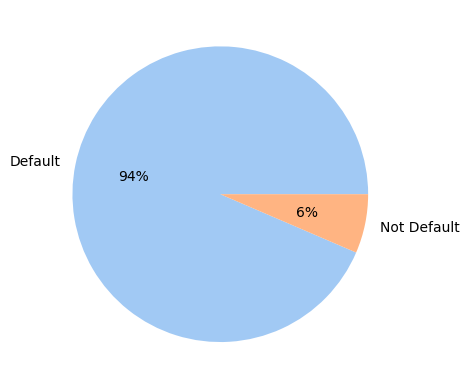

In [952]:
data = df['default_12m'].value_counts()
colors = sns.color_palette('pastel')[0:5]
labels = ['Default', 'Not Default']

plt.pie(data, labels=labels, colors=colors, autopct='%.0f%%')
plt.show()

# Data Preprocessing and Feature Selection

### Data Preprocessing

In [953]:
# Joining tables
df = pd.concat([train_df, test_df], sort=False)

In [954]:
# Dropping absolute features
df.drop(['ar_revenue', 'ar_total_expenses', 'ar_sale_cost', 'ar_selling_expenses', 'ar_management_expenses',
    'ar_sale_profit', 'ar_balance_of_rvns_and_expns', 'ar_profit_before_tax', 'ar_taxes', 
    'ar_other_profit_and_losses'], axis = 1, inplace=True)

In [955]:
df['ul_systematizing_flg'].unique()

array([0])

In [956]:
# Only one value – deleting
df.drop(['ul_systematizing_flg'], axis = 1, inplace = True)

In [957]:
df['ul_staff_range'].unique()

array(['[1-100]', '(100-500]', '> 500'], dtype=object)

In [958]:
# Target encoding categorical feature
encoder = TargetEncoder()
df['ul_staff_range'] = encoder.fit_transform(df['ul_staff_range'], df['record_id'])

In [959]:
# Dropping NaN columns
tmp = df[df.columns.difference(['record_id', 'default_12m'])].isna().any()
df.drop(tmp.index[tmp], axis=1, inplace=True)

In [960]:
a_1 = df['bus_age']
a_2 = df['ogrn_age']
a_3 = df['adr_actual_age']
a_4 = df['head_actual_age']
a_5 = df['cap_actual_age']
ul_1 = df['ul_staff_range']
ul_2 = df['ul_capital_sum']
ul_3 = df['ul_founders_cnt']
ul_4 = df['ul_branch_cnt']
ul_5 = df['ul_strategic_flg']

In [961]:
# A+B
df['add_a1_a2'] = a_1 + a_2
df['add_a1_a3'] = a_1 + a_3
df['add_a1_a4'] = a_1 + a_4
df['add_a1_a5'] = a_1 + a_5
df['add_a1_u1'] = a_1 + ul_1
df['add_a1_u2'] = a_1 + ul_2
df['add_a1_u3'] = a_1 + ul_3
df['add_a1_u4'] = a_1 + ul_4
df['add_a1_u5'] = a_1 + ul_5

df['add_a2_a3'] = a_2 + a_3
df['add_a2_a4'] = a_2 + a_4
df['add_a2_a5'] = a_2 + a_5
df['add_a2_u1'] = a_2 + ul_1
df['add_a2_u2'] = a_2 + ul_2
df['add_a2_u3'] = a_2 + ul_3
df['add_a2_u4'] = a_2 + ul_4
df['add_a2_u5'] = a_2 + ul_5

df['add_a3_a4'] = a_3 + a_4
df['add_a3_u5'] = a_3 + a_5
df['add_a3_u1'] = a_3 + ul_1
df['add_a3_u2'] = a_3 + ul_2
df['add_a3_u3'] = a_3 + ul_3
df['add_a3_u4'] = a_3 + ul_4
df['add_a3_u5'] = a_3 + ul_5

df['add_a4_a5'] = a_4 + a_5
df['add_a4_u1'] = a_4 + ul_1
df['add_a4_u2'] = a_4 + ul_2
df['add_a4_u3'] = a_4 + ul_3
df['add_a4_u4'] = a_4 + ul_4
df['add_a4_u5'] = a_4 + ul_5

df['add_a5_u1'] = a_5 + ul_1
df['add_a5_u2'] = a_5 + ul_2
df['add_a5_u3'] = a_5 + ul_3
df['add_a5_u4'] = a_5 + ul_4
df['add_a5_u5'] = a_5 + ul_5

df['add_u1_u2'] = ul_1 + ul_2
df['add_u1_u3'] = ul_1 + ul_3
df['add_u1_u4'] = ul_1 + ul_4
df['add_u1_u5'] = ul_1 + ul_5

df['add_u2_u3'] = ul_2 + ul_3
df['add_u2_u4'] = ul_2 + ul_4
df['add_u2_u5'] = ul_2 + ul_5

df['add_u3_u4'] = ul_3 + ul_4
df['add_u3_u5'] = ul_3 + ul_5

df['add_u4_u5'] = ul_4 + ul_5

In [962]:
# A-B
df['sub_a1_a2'] = a_1 - a_2
df['sub_a1_a3'] = a_1 - a_3
df['sub_a1_a4'] = a_1 - a_4
df['sub_a1_a5'] = a_1 - a_5
df['sub_a1_u1'] = a_1 - ul_1
df['sub_a1_u2'] = a_1 - ul_2
df['sub_a1_u3'] = a_1 - ul_3
df['sub_a1_u4'] = a_1 - ul_4
df['sub_a1_u5'] = a_1 - ul_5

df['sub_a2_a3'] = a_2 - a_3
df['sub_a2_a4'] = a_2 - a_4
df['sub_a2_a5'] = a_2 - a_5
df['sub_a2_u1'] = a_2 - ul_1
df['sub_a2_u2'] = a_2 - ul_2
df['sub_a2_u3'] = a_2 - ul_3
df['sub_a2_u4'] = a_2 - ul_4
df['sub_a2_u5'] = a_2 - ul_5

df['sub_a3_a4'] = a_3 - a_4
df['sub_a3_u5'] = a_3 - a_5
df['sub_a3_u1'] = a_3 - ul_1
df['sub_a3_u2'] = a_3 - ul_2
df['sub_a3_u3'] = a_3 - ul_3
df['sub_a3_u4'] = a_3 - ul_4
df['sub_a3_u5'] = a_3 - ul_5

df['sub_a4_a5'] = a_4 - a_5
df['sub_a4_u1'] = a_4 - ul_1
df['sub_a4_u2'] = a_4 - ul_2
df['sub_a4_u3'] = a_4 - ul_3
df['sub_a4_u4'] = a_4 - ul_4
df['sub_a4_u5'] = a_4 - ul_5

df['sub_a5_u1'] = a_5 - ul_1
df['sub_a5_u2'] = a_5 - ul_2
df['sub_a5_u3'] = a_5 - ul_3
df['sub_a5_u4'] = a_5 - ul_4
df['sub_a5_u5'] = a_5 - ul_5

df['sub_u1_u2'] = ul_1 - ul_2
df['sub_u1_u3'] = ul_1 - ul_3
df['sub_u1_u4'] = ul_1 - ul_4
df['sub_u1_u5'] = ul_1 - ul_5

df['sub_u2_u3'] = ul_2 - ul_3
df['sub_u2_u4'] = ul_2 - ul_4
df['sub_u2_u5'] = ul_2 - ul_5

df['sub_u3_u4'] = ul_3 - ul_4
df['sub_u3_u5'] = ul_3 - ul_5

df['sub_u4_u5'] = ul_4 - ul_5

In [963]:
# A/B
# df['div_a1_a2'] = a_1 / a_2
# df['div_a1_a3'] = a_1 / a_3
# df['div_a1_a4'] = a_1 / a_4
# df['div_a1_a5'] = a_1 / a_5
# df['div_a1_u1'] = a_1 / ul_1
# df['div_a1_u2'] = a_1 / ul_2
# df['div_a1_u3'] = a_1 / ul_3
# df['div_a1_u4'] = a_1 / ul_4
# df['div_a1_u5'] = a_1 / ul_5

# df['div_a2_a3'] = a_2 / a_3
# df['div_a2_a4'] = a_2 / a_4
# df['div_a2_a5'] = a_2 / a_5
# df['div_a2_u1'] = a_2 / ul_1
# df['div_a2_u2'] = a_2 / ul_2
# df['div_a2_u3'] = a_2 / ul_3
# df['div_a2_u4'] = a_2 / ul_4
# df['div_a2_u5'] = a_2 / ul_5

# df['div_a3_a4'] = a_3 / a_4
# df['div_a3_u5'] = a_3 / a_5
# df['div_a3_u1'] = a_3 / ul_1
# df['div_a3_u2'] = a_3 / ul_2
# df['div_a3_u3'] = a_3 / ul_3
# df['div_a3_u4'] = a_3 / ul_4
# df['div_a3_u5'] = a_3 / ul_5

# df['div_a4_a5'] = a_4 / a_5
# df['div_a4_u1'] = a_4 / ul_1
# df['div_a4_u2'] = a_4 / ul_2
# df['div_a4_u3'] = a_4 / ul_3
# df['div_a4_u4'] = a_4 / ul_4
# df['div_a4_u5'] = a_4 / ul_5

# df['div_a5_u1'] = a_5 / ul_1
# df['div_a5_u2'] = a_5 / ul_2
# df['div_a5_u3'] = a_5 / ul_3
# df['div_a5_u4'] = a_5 / ul_4
# df['div_a5_u5'] = a_5 / ul_5

# df['div_u1_u2'] = ul_1 / ul_2
# df['div_u1_u3'] = ul_1 / ul_3
# df['div_u1_u4'] = ul_1 / ul_4
# df['div_u1_u5'] = ul_1 / ul_5

# df['div_u2_u3'] = ul_2 / ul_3
# df['div_u2_u4'] = ul_2 / ul_4
# df['div_u2_u5'] = ul_2 / ul_5

# df['div_u3_u4'] = ul_3 / ul_4
# df['div_u3_u5'] = ul_3 / ul_5

# df['div_u4_u5'] = ul_4 / ul_5

In [964]:
# A*B
df['mul_a1_a2'] = a_1 * a_2
df['mul_a1_a3'] = a_1 * a_3
df['mul_a1_a4'] = a_1 * a_4
df['mul_a1_a5'] = a_1 * a_5
df['mul_a1_u1'] = a_1 * ul_1
df['mul_a1_u2'] = a_1 * ul_2
df['mul_a1_u3'] = a_1 * ul_3
df['mul_a1_u4'] = a_1 * ul_4
df['mul_a1_u5'] = a_1 * ul_5

df['mul_a2_a3'] = a_2 * a_3
df['mul_a2_a4'] = a_2 * a_4
df['mul_a2_a5'] = a_2 * a_5
df['mul_a2_u1'] = a_2 * ul_1
df['mul_a2_u2'] = a_2 * ul_2
df['mul_a2_u3'] = a_2 * ul_3
df['mul_a2_u4'] = a_2 * ul_4
df['mul_a2_u5'] = a_2 * ul_5

df['mul_a3_a4'] = a_3 * a_4
df['mul_a3_u5'] = a_3 * a_5
df['mul_a3_u1'] = a_3 * ul_1
df['mul_a3_u2'] = a_3 * ul_2
df['mul_a3_u3'] = a_3 * ul_3
df['mul_a3_u4'] = a_3 * ul_4
df['mul_a3_u5'] = a_3 * ul_5

df['mul_a4_a5'] = a_4 * a_5
df['mul_a4_u1'] = a_4 * ul_1
df['mul_a4_u2'] = a_4 * ul_2
df['mul_a4_u3'] = a_4 * ul_3
df['mul_a4_u4'] = a_4 * ul_4
df['mul_a4_u5'] = a_4 * ul_5

df['mul_a5_u1'] = a_5 * ul_1
df['mul_a5_u2'] = a_5 * ul_2
df['mul_a5_u3'] = a_5 * ul_3
df['mul_a5_u4'] = a_5 * ul_4
df['mul_a5_u5'] = a_5 * ul_5

df['mul_u1_u2'] = ul_1 * ul_2
df['mul_u1_u3'] = ul_1 * ul_3
df['mul_u1_u4'] = ul_1 * ul_4
df['mul_u1_u5'] = ul_1 * ul_5

df['mul_u2_u3'] = ul_2 * ul_3
df['mul_u2_u4'] = ul_2 * ul_4
df['mul_u2_u5'] = ul_2 * ul_5

df['mul_u3_u4'] = ul_3 * ul_4
df['mul_u3_u5'] = ul_3 * ul_5

df['mul_u4_u5'] = ul_4 * ul_5

In [965]:
# Splitting back to train and test
test_df = df.iloc[-200:,:]
train_df = df.iloc[:-200, :]
# Just for my convenience
test_record_id = test_df['record_id']

### Feature Selection

In [966]:
# Train Test Split with 0.7 to 0.3 ratio
X_train, X_test, y_train, y_test = train_test_split(train_df, train_df['default_12m'], test_size=0.33, random_state=1)

In [967]:
# Feature selection using Anova-F
def select_features(X_train, y_train, X_test):
	fs = SelectKBest(score_func=f_classif, k='all')
	fs.fit(X_train, y_train)
	X_train_fs = fs.transform(X_train)
	X_test_fs = fs.transform(X_test)
	return X_train_fs, X_test_fs, fs

In [968]:
# Feature selection
X_train_fs, X_test_fs, fs = select_features(X_train, y_train, X_test)

# Feature Scores
features = ['record_id']
for i in range(len(fs.scores_)):
	print('Feature %d: %f' % (i, fs.scores_[i]))
	if fs.scores_[i] > 350:
		features.append(df.columns[i])

Feature 0: 0.351080
Feature 1: 258.116178
Feature 2: 330.091756
Feature 3: 54.125917
Feature 4: 54.125917
Feature 5: 54.125917
Feature 6: 3.308958
Feature 7: 7.567975
Feature 8: 12.606673
Feature 9: 4.373569
Feature 10: 0.069897
Feature 11: inf
Feature 12: 305.128554
Feature 13: 283.049755
Feature 14: 283.049755
Feature 15: 283.049755
Feature 16: 21.384821
Feature 17: 7.568405
Feature 18: 146.158766
Feature 19: 258.264489
Feature 20: 258.116406
Feature 21: 356.463935
Feature 22: 356.463935
Feature 23: 356.463935
Feature 24: 14.599794
Feature 25: 7.568277
Feature 26: 124.172571
Feature 27: 330.402139
Feature 28: 330.092203
Feature 29: 54.125917
Feature 30: 54.129448
Feature 31: 3.961142
Feature 32: 7.568001
Feature 33: 18.892036
Feature 34: 54.984326
Feature 35: 54.125917
Feature 36: 3.961142
Feature 37: 7.568001
Feature 38: 18.892036
Feature 39: 54.984326
Feature 40: 54.129448
Feature 41: 3.961142
Feature 42: 7.568001
Feature 43: 18.892036
Feature 44: 54.984326
Feature 45: 54.129448
Fe

In [969]:
list(train_df.columns.values)

['record_id',
 'bus_age',
 'ogrn_age',
 'adr_actual_age',
 'head_actual_age',
 'cap_actual_age',
 'ul_staff_range',
 'ul_capital_sum',
 'ul_founders_cnt',
 'ul_branch_cnt',
 'ul_strategic_flg',
 'default_12m',
 'add_a1_a2',
 'add_a1_a3',
 'add_a1_a4',
 'add_a1_a5',
 'add_a1_u1',
 'add_a1_u2',
 'add_a1_u3',
 'add_a1_u4',
 'add_a1_u5',
 'add_a2_a3',
 'add_a2_a4',
 'add_a2_a5',
 'add_a2_u1',
 'add_a2_u2',
 'add_a2_u3',
 'add_a2_u4',
 'add_a2_u5',
 'add_a3_a4',
 'add_a3_u5',
 'add_a3_u1',
 'add_a3_u2',
 'add_a3_u3',
 'add_a3_u4',
 'add_a4_a5',
 'add_a4_u1',
 'add_a4_u2',
 'add_a4_u3',
 'add_a4_u4',
 'add_a4_u5',
 'add_a5_u1',
 'add_a5_u2',
 'add_a5_u3',
 'add_a5_u4',
 'add_a5_u5',
 'add_u1_u2',
 'add_u1_u3',
 'add_u1_u4',
 'add_u1_u5',
 'add_u2_u3',
 'add_u2_u4',
 'add_u2_u5',
 'add_u3_u4',
 'add_u3_u5',
 'add_u4_u5',
 'sub_a1_a2',
 'sub_a1_a3',
 'sub_a1_a4',
 'sub_a1_a5',
 'sub_a1_u1',
 'sub_a1_u2',
 'sub_a1_u3',
 'sub_a1_u4',
 'sub_a1_u5',
 'sub_a2_a3',
 'sub_a2_a4',
 'sub_a2_a5',
 'sub_

In [970]:
train_df = train_df[features]
test_df = test_df[features]

# Hyperparameter Tuning

### Gradient Boosting

In [971]:
train_df

,record_id,default_12m,add_a2_a3,add_a2_a4,add_a2_a5
0,7,0.0,139,139,139
1,13,0.0,147,147,147
2,18,0.0,61,61,61
3,22,0.0,147,147,147
4,23,0.0,165,165,165
...,...,...,...,...,...
32390,274590,0.0,76,76,76
32391,274593,0.0,166,166,166
32392,274602,0.0,22,22,22
32393,274611,1.0,83,83,83


In [972]:
# Chosen Parameters for Gradient Boosting Classifier
learning_rate = [x for x in np.linspace(0.01, 1, 10)]
n_estimators = [int(x) for x in np.linspace(1, 200, 10)]
max_depth = [int(x) for x in np.linspace(1, 32, 32)]
min_samples_split = [int(x) for x in np.linspace(1, 50, 10)]
min_samples_leaf = [int(x) for x in np.linspace(1, 50, 10)]
max_features = [int(x) for x in np.linspace(1, 15, 15)]

In [973]:
# Random Grid for Randomized Search
random_grid = {'learning_rate': learning_rate,
    'n_estimators': n_estimators,
    'max_depth': max_depth,
    'min_samples_split': min_samples_split,
    'min_samples_leaf': min_samples_leaf,
    'max_features': max_features
}

In [974]:
train_df

,record_id,default_12m,add_a2_a3,add_a2_a4,add_a2_a5
0,7,0.0,139,139,139
1,13,0.0,147,147,147
2,18,0.0,61,61,61
3,22,0.0,147,147,147
4,23,0.0,165,165,165
...,...,...,...,...,...
32390,274590,0.0,76,76,76
32391,274593,0.0,166,166,166
32392,274602,0.0,22,22,22
32393,274611,1.0,83,83,83


In [975]:
# Instance of the GradientBoostingClassifier
gb = GradientBoostingClassifier()

# Instance of the RandomizedSearchCV
gb_random = RandomizedSearchCV(estimator = gb,
    param_distributions = random_grid,
    n_iter = 100,
    cv = 3,
    verbose=2,
    random_state=42,
    n_jobs = -1)

# Fitting the RSCV
gb_random.fit(train_df.drop(['default_12m', 'record_id'], axis=1), train_df['default_12m'])

# Output Parameters
gb_p = list(gb_random.best_params_.values())

Fitting 3 folds for each of 100 candidates, totalling 300 fits
[CV] END learning_rate=0.34, max_depth=17, max_features=13, min_samples_leaf=39, min_samples_split=22, n_estimators=67; total time=   0.0s
[CV] END learning_rate=0.45, max_depth=21, max_features=15, min_samples_leaf=22, min_samples_split=44, n_estimators=200; total time=   0.0s
[CV] END learning_rate=0.34, max_depth=9, max_features=11, min_samples_leaf=1, min_samples_split=1, n_estimators=133; total time=   0.0s
[CV] END learning_rate=0.34, max_depth=9, max_features=11, min_samples_leaf=1, min_samples_split=1, n_estimators=133; total time=   0.0s
[CV] END learning_rate=0.34, max_depth=9, max_features=11, min_samples_leaf=1, min_samples_split=1, n_estimators=133; total time=   0.0s
[CV] END learning_rate=0.23, max_depth=12, max_features=12, min_samples_leaf=1, min_samples_split=39, n_estimators=89; total time=   0.0s
[CV] END learning_rate=0.23, max_depth=12, max_features=12, min_samples_leaf=1, min_samples_split=39, n_estim

### CatBoost

In [976]:
# Chosen Parameters for CatBoostClassifier
learning_rate = [x for x in np.linspace(0.001, 0.01, 50)]
depth = [x for x in np.linspace(4, 10, 7)]
l2_leaf_reg = [x for x in np.linspace(2, 10, 9)]
random_strength = [x for x in np.linspace(0, 10, 11)]

In [977]:
# Random Grid for Randomized Search
random_grid = {'learning_rate': learning_rate,
    'depth': depth,
    'l2_leaf_reg': l2_leaf_reg,
    'random_strength': random_strength
}

In [978]:
# Instance of the CatBoostClassifier
cb = CatBoostClassifier(silent=True)

# Instance of the RandomizedSearchCV
cb_random = RandomizedSearchCV(estimator = cb,
    param_distributions = random_grid,
    n_iter = 100,
    cv = 3,
    verbose=2,
    random_state=42,
    n_jobs = -1)

# Fitting the RSCV
cb_random.fit(train_df.drop(['default_12m', 'record_id'], axis=1), train_df['default_12m'])

# Output Parameters
cb_p = list(cb_random.best_params_.values())

Fitting 3 folds for each of 100 candidates, totalling 300 fits
[CV] END depth=4.0, l2_leaf_reg=3.0, learning_rate=0.0061428571428571435, random_strength=2.0; total time=   6.0s
[CV] END depth=4.0, l2_leaf_reg=3.0, learning_rate=0.0061428571428571435, random_strength=2.0; total time=   6.0s
[CV] END depth=4.0, l2_leaf_reg=3.0, learning_rate=0.0061428571428571435, random_strength=2.0; total time=   6.1s
[CV] END depth=6.0, l2_leaf_reg=4.0, learning_rate=0.005591836734693878, random_strength=9.0; total time=   6.9s
[CV] END depth=6.0, l2_leaf_reg=4.0, learning_rate=0.005591836734693878, random_strength=9.0; total time=   6.9s
[CV] END depth=7.0, l2_leaf_reg=3.0, learning_rate=0.007428571428571429, random_strength=10.0; total time=   7.6s
[CV] END depth=7.0, l2_leaf_reg=3.0, learning_rate=0.007428571428571429, random_strength=10.0; total time=   7.8s
[CV] END depth=7.0, l2_leaf_reg=3.0, learning_rate=0.007428571428571429, random_strength=10.0; total time=   7.9s
[CV] END depth=5.0, l2_leaf

### GaussianNB

In [979]:
# Only one available parameter to tune =(
random_grid = {'var_smoothing': np.logspace(0,-9, num=100)}

# Instance of the GaussianNB
gnb = GaussianNB()

# Instance of the RandomizedSearchCV
gnb_random = RandomizedSearchCV(estimator = gnb,
    param_distributions = random_grid,
    n_iter = 100,
    cv = 3,
    verbose=2,
    random_state=42,
    n_jobs = -1)

# Fitting the RSCV
gnb_random.fit(train_df.drop(['default_12m', 'record_id'], axis=1), train_df['default_12m'])

# Output Parameters
gnb_p = list(gnb_random.best_params_.values())

Fitting 3 folds for each of 100 candidates, totalling 300 fits
[CV] END ..................................var_smoothing=1.0; total time=   0.0s
[CV] END ..................................var_smoothing=1.0; total time=   0.0s
[CV] END ..................................var_smoothing=1.0; total time=   0.0s
[CV] END ...................var_smoothing=0.8111308307896871; total time=   0.0s
[CV] END ...................var_smoothing=0.8111308307896871; total time=   0.0s
[CV] END ....................var_smoothing=0.657933224657568; total time=   0.0s
[CV] END ...................var_smoothing=0.8111308307896871; total time=   0.0s
[CV] END ....................var_smoothing=0.657933224657568; total time=   0.0s
[CV] END ....................var_smoothing=0.657933224657568; total time=   0.0s
[CV] END ....................var_smoothing=0.533669923120631; total time=   0.0s
[CV] END ....................var_smoothing=0.533669923120631; total time=   0.0s
[CV] END ....................var_smoothing=0.5

# Modelling and Evaluation

In [980]:
# Get a stacking ensemble of models
def get_stacking():
    # Defining the base models
    estimators = list()
    estimators.append(('GradientBoosting', GradientBoostingClassifier(
        n_estimators=gb_p[0],
        min_samples_split=gb_p[1],
        min_samples_leaf=gb_p[2],
        max_features=gb_p[3],
        max_depth=gb_p[4],
        learning_rate=gb_p[5])))
    estimators.append(('CatBoost', CatBoostClassifier(
        silent=True,
        depth=cb_p[0],
        learning_rate=cb_p[1],
        l2_leaf_reg=cb_p[2],
        random_strength=cb_p[3]
        )))
    estimators.append(('GaussianNB', GaussianNB(var_smoothing=gnb_p[0])))
    # Defining meta learner model
    final_estimator = LogisticRegression()
    # Defining the stacking ensemble
    model = StackingClassifier(estimators=estimators, final_estimator=final_estimator, cv=5)
    return model

In [981]:
# Evaluate a given model using cross-validation
def roc_auc_evaluate_model(model, x, y):
    start_time = time.time()
    cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
    scores = cross_val_score(model, x, y, scoring='roc_auc', cv=cv, n_jobs=-1, error_score='raise')
    run_time = time.time() - start_time
    return scores, run_time

In [982]:
# Get the models to evaluate
model = get_stacking()
roc_auc_results, runs = list(), list()

# Evaluate the models and store results
roc_auc_scores, run_time = roc_auc_evaluate_model(model, train_df.drop('default_12m', axis=1), train_df['default_12m'])
roc_auc_results.append(roc_auc_scores)
runs.append(run_time)
print('Stacking', "| ROC AUC:", mean(roc_auc_scores), "| Standard Deviation:", std(roc_auc_scores),"| Time Taken:", run_time)

Stacking | ROC AUC: 0.6400313085347424 | Standard Deviation: 0.020760159598159206 | Time Taken: 1209.0872552394867


In [983]:
# Instance of the Gradient Boosting Classifier with Hyperparameters
model = GradientBoostingClassifier(
        n_estimators=gb_p[0],
        min_samples_split=gb_p[1],
        min_samples_leaf=gb_p[2],
        max_features=gb_p[3],
        max_depth=gb_p[4],
        learning_rate=gb_p[5])
roc_auc_results, runs = list(), list()

# Evaluate the models and store results
roc_auc_scores, run_time = roc_auc_evaluate_model(model, train_df.drop('default_12m', axis=1), train_df['default_12m'])
roc_auc_results.append(roc_auc_scores)
runs.append(run_time)
print('Gradient Boosting Classifier', "| ROC AUC:", mean(roc_auc_scores), "| Standard Deviation:", std(roc_auc_scores),"| Time Taken:", run_time)

Gradient Boosting Classifier | ROC AUC: 0.5601074610879216 | Standard Deviation: 0.018524034848042648 | Time Taken: 8.714295864105225


In [984]:
# Instance of the CatBoost Classifier with Hyperparameters
model = CatBoostClassifier(
        silent=True,
        depth=cb_p[0],
        learning_rate=cb_p[1],
        l2_leaf_reg=cb_p[2],
        random_strength=cb_p[3])
roc_auc_results, runs = list(), list()

# Evaluate the models and store results
roc_auc_scores, run_time = roc_auc_evaluate_model(model, train_df.drop('default_12m', axis=1), train_df['default_12m'])
roc_auc_results.append(roc_auc_scores)
runs.append(run_time)
print('CatBoost Classifier', "| ROC AUC:", mean(roc_auc_scores), "| Standard Deviation:", std(roc_auc_scores),"| Time Taken:", run_time)

CatBoost Classifier | ROC AUC: 0.6404942438344616 | Standard Deviation: 0.021041796228292026 | Time Taken: 174.82088494300842


In [985]:
# Instance of the GaussianNB with Hyperparameter
model = GaussianNB(var_smoothing=gnb_p[0])
roc_auc_results, runs = list(), list()

# Evaluate the models and store results
roc_auc_scores, run_time = roc_auc_evaluate_model(model, train_df.drop('default_12m', axis=1), train_df['default_12m'])
roc_auc_results.append(roc_auc_scores)
runs.append(run_time)
print('Gradient Boosting Classifier', "| ROC AUC:", mean(roc_auc_scores), "| Standard Deviation:", std(roc_auc_scores),"| Time Taken:", run_time)

Gradient Boosting Classifier | ROC AUC: 0.49642717819397914 | Standard Deviation: 0.016669437232459026 | Time Taken: 0.19055485725402832


# Results

In [986]:
# Instance of the Catboost Classifier
model = CatBoostClassifier(
        silent=True,
        depth=cb_p[0],
        learning_rate=cb_p[1],
        l2_leaf_reg=cb_p[2],
        random_strength=cb_p[3])
# Fitting the Model
model.fit(train_df.drop(['record_id', 'default_12m'], axis=1), train_df['default_12m'])
# Getting Predictions
cat_predictions = model.predict(test_df.drop(['record_id', 'default_12m'], axis=1))

# Results
answ_df = pd.DataFrame()
answ_df['id'] = test_record_id
predict = pd.DataFrame([math.floor(float(x)) for x in (predictions*100)])
answ_df['predict'] = predict
answ_df.to_csv('PD-CAT-submit.csv',index=False, sep=';')

In [987]:
# Instance of the GradientBoosting Classifier
model = model = GradientBoostingClassifier(
        n_estimators=gb_p[0],
        min_samples_split=gb_p[1],
        min_samples_leaf=gb_p[2],
        max_features=gb_p[3],
        max_depth=gb_p[4],
        learning_rate=gb_p[5])
# Fitting the Model
model.fit(train_df.drop(['record_id', 'default_12m'], axis=1), train_df['default_12m'])
# Getting Predictions
gradient_predictions = model.predict(test_df.drop(['record_id', 'default_12m'], axis=1))

# Results
answ_df = pd.DataFrame()
answ_df['id'] = test_record_id
predict = pd.DataFrame([math.floor(float(x)) for x in (predictions*100)])
answ_df['predict'] = predict
answ_df.to_csv('PD-GRADIENT-submit.csv',index=False, sep=';')

In [988]:
# Instance of the GaussianNB with Hyperparameter
model = GaussianNB(var_smoothing=gnb_p[0])
# Fitting the Model
model.fit(train_df.drop(['record_id', 'default_12m'], axis=1), train_df['default_12m'])
# Getting Predictions
gaussian_predictions = model.predict(test_df.drop(['record_id', 'default_12m'], axis=1))

# Results
answ_df = pd.DataFrame()
answ_df['id'] = test_record_id
predict = pd.DataFrame([math.floor(float(x)) for x in (predictions*100)])
answ_df['predict'] = predict
answ_df.to_csv('PD-GAUSSIAN-submit.csv',index=False, sep=';')

In [989]:
# Defining the base models
estimators = list()
estimators.append(('GradientBoosting', GradientBoostingClassifier(
    n_estimators=gb_p[0],
    min_samples_split=gb_p[1],
    min_samples_leaf=gb_p[2],
    max_features=gb_p[3],
    max_depth=gb_p[4],
    learning_rate=gb_p[5])))
estimators.append(('CatBoost', CatBoostClassifier(
    silent=True,
    depth=cb_p[0],
    learning_rate=cb_p[1],
    l2_leaf_reg=cb_p[2],
    random_strength=cb_p[3])))
estimators.append(('GaussianNB', GaussianNB(var_smoothing=gnb_p[0])))
# Defining meta learner model
final_estimator = LogisticRegression()
# Defining the stacking ensemble
model = StackingClassifier(estimators=estimators, final_estimator=final_estimator, cv=5)
# Fitting the Model
model.fit(train_df.drop(['record_id', 'default_12m'], axis=1), train_df['default_12m'])
# Getting Predictions
stacking_predictions = model.predict(test_df.drop(['record_id', 'default_12m'], axis=1))

# Results
answ_df = pd.DataFrame()
answ_df['id'] = test_record_id
predict = pd.DataFrame([math.floor(float(x)) for x in (predictions*100)])
answ_df['predict'] = predict
answ_df.to_csv('PD-STACKING-submit.csv',index=False, sep=';')